In [1]:
import spot, buddy
spot.setup()
from buddy import bddfalse

The `backprop_graph` object is a directed graph that helps in solving reachability games in linear time.  It can be used either offline (create the entire graph, then designate winning states and propagate that winning condition to find the winning region) or online (propagate the winning condition during the construction of the graph).


Each node of the graph has an *owner* represented by a Boolean:
  - states owned by player `False` are represented with rounded boxes
  - states owned by player `True` are represented with diamond nodes

Each node as a Boolean `determined` that indicates if the winner for this node is known.

Each node as a Boolean `winner` that should only be read if `determined` is true: 
  - `True`, meaning winning for player `True` (this will be represented by green nodes), 
  - `False`, meaning winning for player `False` (represented by red nodes).
  
Undeterminate will be represented as white nodes.

To deal with the online setting, a node also has a Boolean `frozen`.  Frozen nodes will be represented with a solid enclosure, and unfrozen now with a dashed enclosure.  Once a node is frozen, no outgoing edges can be added.

Finally, each node may store a `choice`.  If the state is won by its owner, `choice` indicates the choice that the owner of the now should make to win.  These *winning choices* will be represented with bold edges.

The API is very small.  A `backprop_graph` may be modified using four functions:
  - `new_state(owner)` creates a state owned by `owner`, and returns its number (sequential numbering from 0).
  - `new_edge(src, dst)` creates an edge from state `src` to state `dst`. 
  - `freeze_state(num)` declares that no new outgoing edges will be added to state `num`.
  - `set_winner(num, b)` sets the winner of an undeterminate state `num` to `b` (which can be True or False) and propagate that information backward in the graph.
  
Internally, only the predecessor relation of the graph is stored, and each state additionally stores a counter of undeterminate successors.  When that counter drops to zero on a frozen state, the status of that state can be determined.

# Offline reachability

In a standard *reachability game*, a player wants to reach one state of a *target* set regardless of the choices made by the other player.

Other game algorithms in Spot assume that player 1 is trying to satisfy the acceptance condition, and player 0 is fighting against it.  Therefore, we are going to assume that player `True` wants to reach the *target* set, and player `False` wants to prevent that.

In an offline setup, we first create the graph in which the nodes are owned by the player that should play for that state. Then we set the status of all states in the target set as True.  After back-propagation, we check if the initial state (or any other state if we are interested) has status True, meaning that player True can win from that state.   

The False status is not necessary in this setup: only the True status is propagated, and after backpropagation, undeterminate state are considered as winning for the False player (meaning that the False player as a way to prevent the True player from reaching any target state).

Here is a s small example taken from [Section 3.1 of these lecture notes](https://finkbeiner.groups.cispa.de/teaching/infinite-games-16/lecture-notes.pdf).  (Player 0 in those lecture notes corresponds to player True here.) 

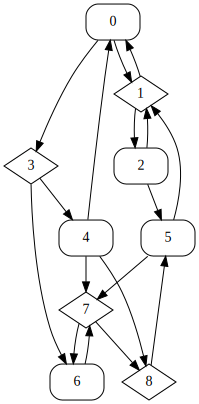

In [2]:
def example():
    g = spot.backprop_graph(False)
    for s in (False, True, False,
              True, False, False,
              False, True, True):
        g.new_state(s)
    for (src, dst) in ((0, 1), (0, 3), (1, 0), (1, 2),
                       (2, 1), (2, 5), (3, 4), (3, 6),
                       (4, 0), (4, 7), (4, 8), (5, 1),
                       (5, 7), (6, 7), (7, 6), (7, 8),
                       (8, 5)):
        g.new_edge(src, dst)
    for s in range(9):
        g.freeze_state(s)
    return g
g = example()
g

Marking state 5 as accepting for the player True will immediately propagate this information to its predecessors {2,8} as follows:

- state 8 is owned by True, so since it has a successor with status True, it should update its status to True as well.
- state 2 is owned by False, so we just decrease its counter of undeterminate successors to 1.  If that counter ever reach zero, the state can be determined.
- since the status of state 8 was changed, this status is propagated to its predecessors in the same way:
    - state 4 is owned by False, its counter of undeterminate successors is decreased to 2
    - state 7 is owned by True, so its status is changed to True
    - since the status of state 7 was changed, it is propagated to predecessor states:
        - state 5 is already determined, so its status is not changed
        - state 4 is owned by False, so its counter of undetermined successors is decreased to 1 
        - state 6 is owned by False, its counter of undetermined successors is decreased to 0, and therefore its status is changed to True (because all its successors have status True, any move from player False is winning for player True)
        - since the status of state 6 was changed, this status is propagated to predecessors:
            - states 7 is already determined, so its status is not changed
            - state 3 is owned by True, so its status is changed to True
            - since state 3's status was changed, this status is propagated to predecessors:
                - state 0 is owned by False so its counter of undeterminate successors is decreased to 1

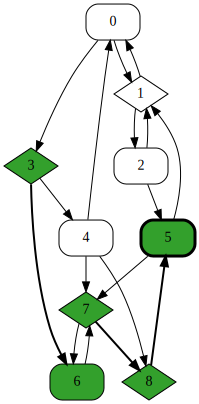

In [3]:
g.set_winner(5, True); g

In the original example, state 4 was also part of the target set.  We can do that here too, but since all predecessors of that state are determined, it does not cause further propagation.

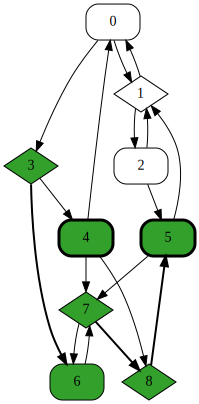

In [4]:
g.set_winner(4, True); g

# Dual targets

The `True` and `False` statuses of the API allow to designate a target set for each player.  

For instance we could decide that player `False` should reach state 5, and player `True` should reach state 7.  In that case, the underterminate states after propagation are the states where no player have a winning strategy to reach their respective target states.

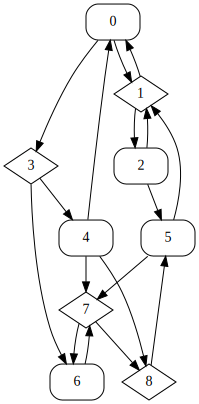

In [5]:
g = example(); g

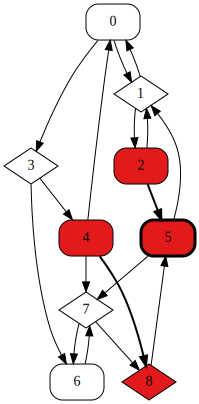

In [6]:
g.set_winner(5, False); g

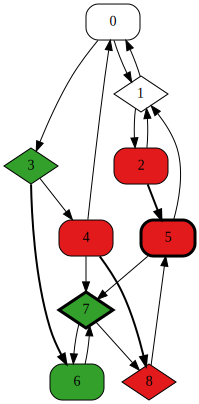

In [7]:
g.set_winner(7, True); g

The propagation of winners work similarily for both players/colors:

If a the winner of an undeterminate state is changed to `b`, iterate over every predecessor `p`:
- if `p` is determined, do nothing
- else if `p` is owned by `b`, set its status to `b`
- else (`p` is necessarily owned by `!b`) decrease its counter of undeterminate successors and if that counter reaches 0, set the status of `p` to `b`.

# Online reachability

Now, we consider cases where the target set might be known in advance, or at least decided when the target states are created.  We want to propagate winning statuses while we are constructing the graph.  Additionally, we are really looking forward to determinate the winner of the initial state (state 0), and we can stop constructing the graph as soon that state 0 is determined.

Typically, during LTLf synthesis, we are building a game in which the environment is trying to reach an accepting sink, and the controller is trying to prevent that.  The accepting sink can be marked as winning for True early in the construction, and if, during the construction of the graph, we can propagate that winning status back to the initial state, we can stop the construction early.   

Dually, if we have a rejecting sink, we can also mark it as winning for False, so that the False winning states gets backpropagated too.  This way, we can also stop early if we discover a winning strategy for False.

Additionally, we can stop exporing the successors of a state as soon as we find out that the state is determined.

Let's review our API again, but with this online setting in mind.  In particular, the `freeze_state()` was not very useful in the offline setting: if propagation occurs after the graph has been built, we can assume that the entire graph is frozen.  But in the online setting, some decisions can only be done if we are sure no successors will be added to a state.

  - `set_winner(num, b)` sets the winner of an undeterminate state `num` to `b` (which can be True or False), and progates that information backward in the graph.   
      - If an undeterminate predecessor is owned by `b`, it can be marked as winning by `b` too.
      - If an undeterminate predecessor is owned by `!b`, its counter of undeterminate successors is decreased by 1.  If that counter reaches 0 *and* if that predecessor is a frozen state, then it can be marked as winning for `b`. 
  - `new_edge(src, dst)` *may* create an edge from state `src` to state `dst`, and *may* update the winner of `src`:
      - if `src` is frozen, an exception is raised: adding an outgoing edge to a frozen state is not permited
      - else if `src` is determined, nothing is done
      - else if `dst` is undeterminate, the edge is added to the list of predecessor of `dst`, and the counter of undeterminate successors of `src` increased by 1
      - else if `dst` is won by `b` and `src` is owned by `b`, then `src` can be marked as winning for `b` (and that should be propagated), but no edge is created.
      - else nothing is done (here `dst` is winning for `b` but `src` is owned by `!b`, so taking this edge would never be in the interest of player `!b`). 
  - `freeze_state(num)` declares that no new edges will be added to state `num`.  
      - If a state owned by `b` has a counter of undeterminate successors equal to 0 when it is frozen, then it  is marked as winning for `!b` (and propagated).

For the purpose of algorithms that want to abort as soon as the initial state is determined, the function `new_edge`, `freeze_state`. and `set_winner` return True iff that call caused the status of state 0 to be changed.

Note that because the `backprop_graph` does not store unecessary edges, the code that performs the graphical display in this notebook can only represent the edge that correspond to the *choice* stored in states won by their owner, and the *predecessors* edges that were added to an undetermined state during the construction.  All edges are visibile in an offline reachability because all states are undetermined during the construction.  But in the online setting, you will see that some edges have been dropped.

## Small manual example

In [8]:
g = spot.backprop_graph()

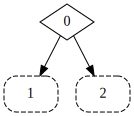

In [9]:
g.new_state(True)  # 0
g.new_state(False) # 1
g.new_state(False) # 2
g.new_edge(0, 1)
g.new_edge(0, 2)
g.freeze_state(0)
g

The dashed states are those that are not frozen, i.e., they can get new successors.

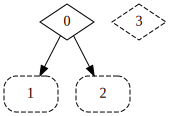

In [10]:
g.new_state(True) # 3
g

In [11]:
# Adding an outgoing edge to a frozen state is not allowed
try:
    g.new_edge(0, 3)
except RuntimeError as e:
    print("expected exception:", str(e))
else:
    assert "missing exception"

expected exception: backprop_graph: cannot add successor to frozen state


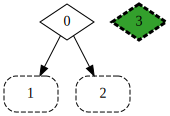

In [12]:
g.set_winner(3, True); g

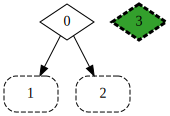

In [13]:
# Adding an edge from a node owned by False to a node winning for True is silently skipped.
# That's a first example of "disappearing" edges.
g.new_edge(2, 3); g

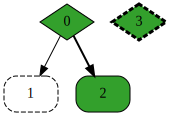

In [14]:
g.freeze_state(2); g

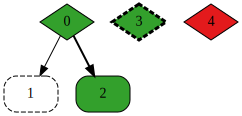

In [15]:
g.new_state(True) # 4
g.freeze_state(4)
g

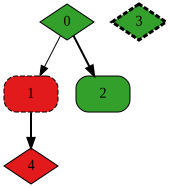

In [16]:
g.new_edge(1, 4) # Updates 1 (even if 1 is not frozen), but does not add a predecessor edge to 4.
g                # The code can still draw the edge because state 1 recorded its choice to be 4.

In [17]:
# cannot change the status of a determined state
try:
    g.set_winner(4, True)
except RuntimeError as e:
    print("expected exception:", str(e))
else:
    assert "missing exception"

expected exception: backprop_graph: cannot change status of determined state


# Offline/online example 2

Let's consider an MTDFA for `G(i8<->Fo8) & (o9 -> G(Xi9<->o8))'` where variables `i?` are played by the environment (player False), and `o?` are played by the controller (player True).  The environment wins when it reachs any accepting terminal, so these terminals can all be merged into a single bddtrue state.

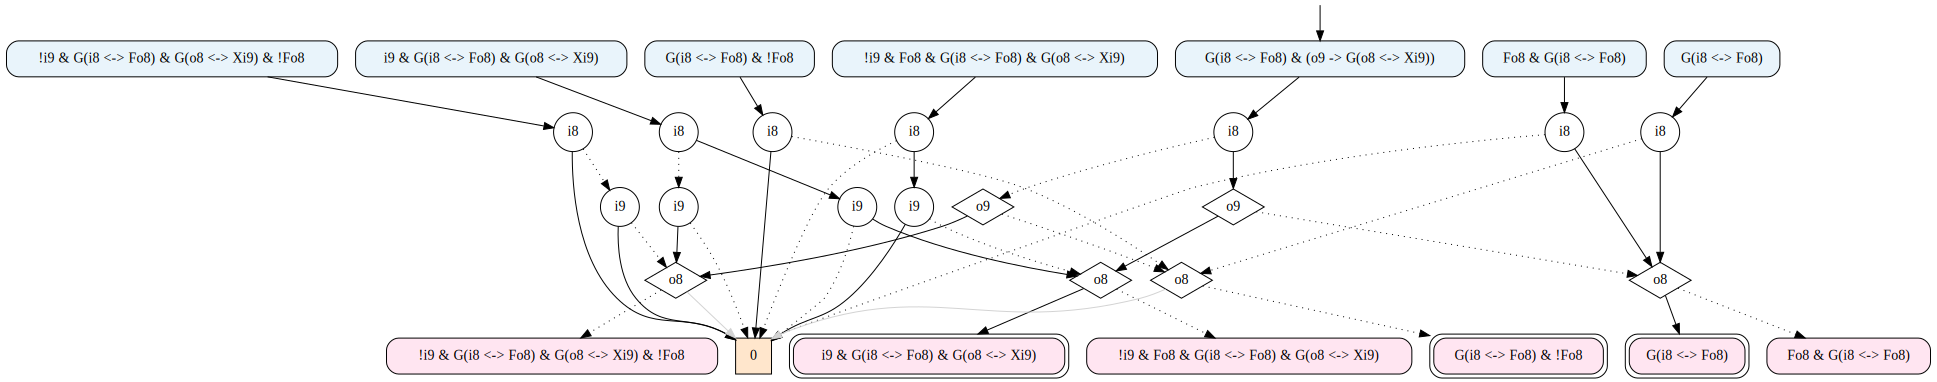

In [18]:
with spot.bdd_dict_preorder("i8", "i9") as d:
    a = spot.ltlf_to_mtdfa('G(i8<->Fo8) & (o9 -> G(Xi9<->o8))', dict=d)
    a.set_controllable_variables(["o8", "o9"])
a

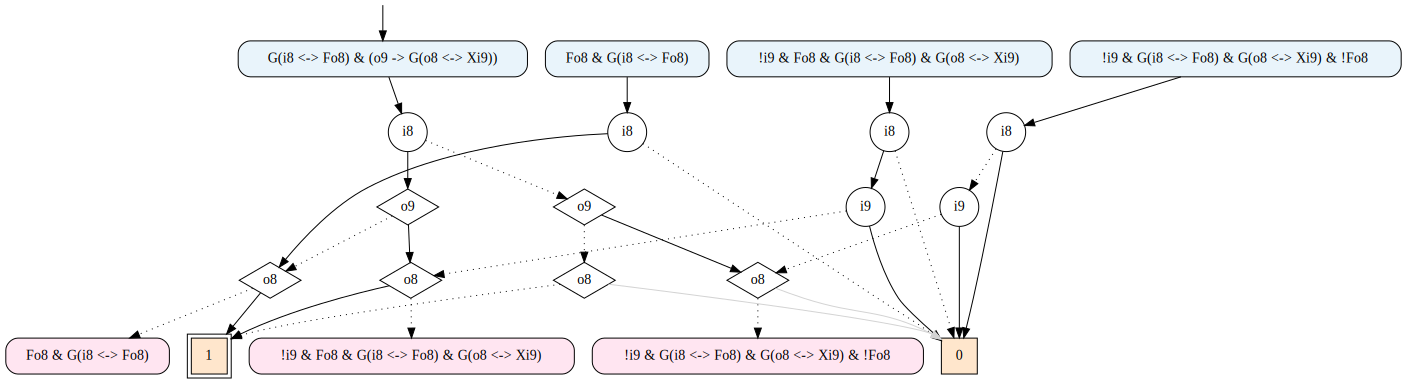

In [19]:
a = spot.mtdfa_restrict_as_game(a); a

Let's write an procedure to turn the above into a `backprop_graph`.  If `online=False` we will not set the status of the `bddfalse` and `bddtrue` node, so that the we force the build of the entire graph.

In [20]:
def convert_to_backprop(a, online=False, display_each_step=False):
    # get the list of controllable BDD variables
    ctrlbdd = a.get_controllable_variables()
    ctrlvar = set()
    while ctrlbdd != buddy.bddtrue:
        ctrlvar.add(buddy.bdd_var(ctrlbdd))
        ctrlbdd = buddy.bdd_high(ctrlbdd)

    g = spot.backprop_graph()
    todo = []
    bdd_to_state = dict()

    def to_state(bdd):
        if bdd not in bdd_to_state:
            if buddy.bdd_is_terminal(bdd): 
                # replace any terminal by the corresponding root
                return to_state(a.states[buddy.bdd_get_terminal(bdd)//2])
            isconst = bdd in (buddy.bddtrue, buddy.bddfalse)
            if isconst: 
                # For bddtrue/bddfalse states, we will create states
                # owned by the other player.  The ownership does not
                # really matters since we will set the status of those
                # states explicitely anyway.  However given that those states
                # have no successors, this will be declared as losing for
                # the owner if they are frozen, so it makes sense to 
                # have the bddtrue states owned by False, and the bddfalse
                # state owned by True.
                owner = bdd != buddy.bddtrue
            else:
                owner = buddy.bdd_var(bdd) in ctrlvar
            s = g.new_state(owner)
            bdd_to_state[bdd] = s
            if not isconst:
                todo.append((s, bdd))
            elif online:
                g.set_winner(s, not owner)
        return bdd_to_state[bdd]

    to_state(a.states[0]) # this initializes todo

    while todo:
        (s, bdd) = todo.pop(0) # BFS-order, but that can be changed.
        if display_each_step:
            display(g)
            print("processing state", s)
        low = buddy.bdd_low(bdd)
        high = buddy.bdd_high(bdd)
        # We can process these two children in any order.
        #
        # If adding the edge to the first children determinates
        # the current state (this can happen if that first 
        # children exists and is determined) then we do not
        # need to process the second child, which might save
        # the creation of a state.
        # Therefore, if high is already a known state, swap 
        # the two children so we process high first. 
        # (This only makes sense in the online setting, but it 
        # does not hurt the offline case.)
        if high in bdd_to_state:
            low, high = high, low
        if g.new_edge(s, to_state(low)):
            break
        if not g.is_determined(s): # s is still undeterminate
            if g.new_edge(s, to_state(high)):
                break
        if g.freeze_state(s):
            break
    return g

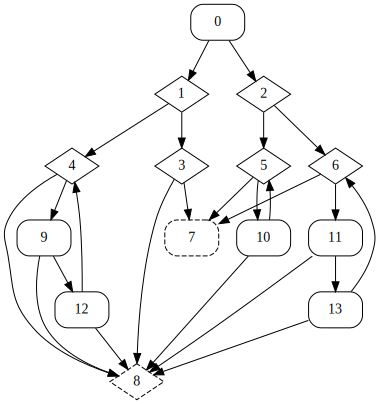

In [21]:
g = convert_to_backprop(a)
g

The two dashed (not frozen) nodes correspond to `bddtrue` (rounded rectangle) and `bddfalse` (diamond).  We can manually mark the node corresponding to `bddtrue` as winning for `True`.  This will propagate all the way up to the initial state:

In [22]:
g.set_winner(7, True)

True

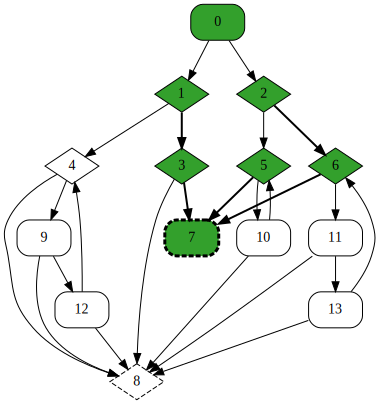

In [23]:
g

To do the same propagation online, we just mark the winning status of the nodes for `bddtrue` and `bddfalse` as soon as we discover them, and we terminate as soon as one of `new_edge()` or `freeze_state()` returns True.  Here is the online conversion, displaying the updated graph after processing each state.  Note that each "processing state N" step is making two calls to `new_edge()`, but edges going to determined state will never need to be added to the graph, so we save some memory even in case the process cannot stop early and process all states.   Also, since some states are skipped, the numbering of the online case will not match the numbering of the offline case.

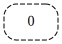

processing state 0


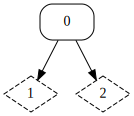

processing state 1


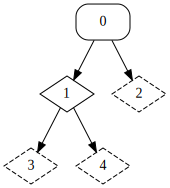

processing state 2


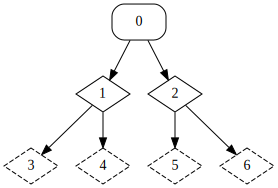

processing state 3


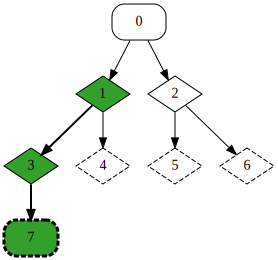

processing state 4


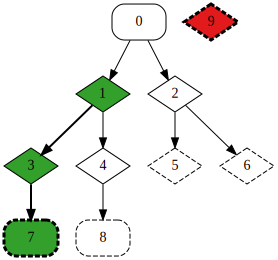

processing state 5


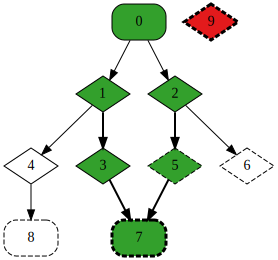

In [24]:
g = convert_to_backprop(a, online=True, display_each_step=True)
g

Let's take the same formula, but we force the controller to play first:

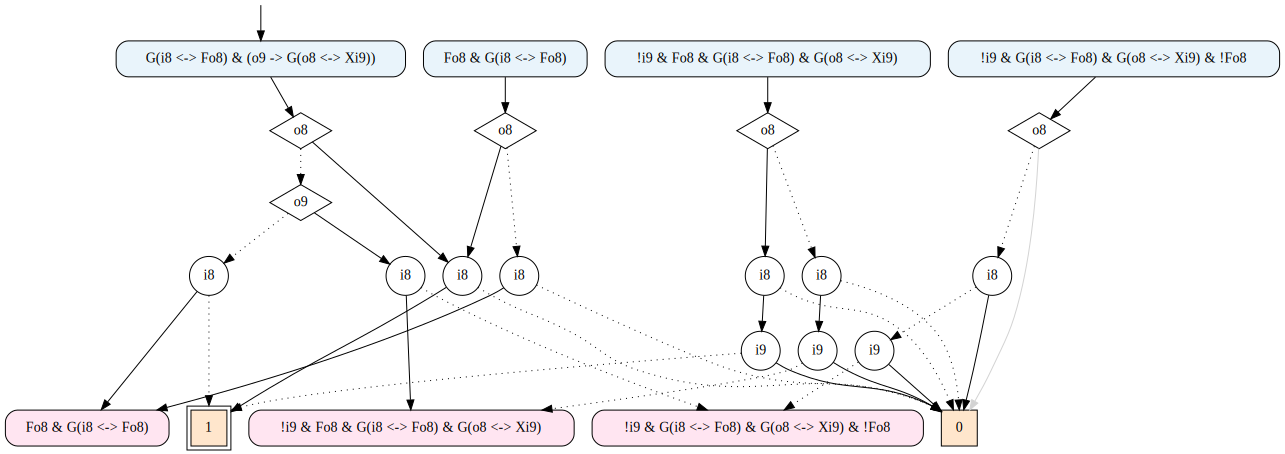

In [25]:
with spot.bdd_dict_preorder("o8", "o9") as d:
    a = spot.ltlf_to_mtdfa('G(i8<->Fo8) & (o9 -> G(Xi9<->o8))', dict=d)
    a.set_controllable_variables(["o8", "o9"])
    a = spot.mtdfa_restrict_as_game(a)
a

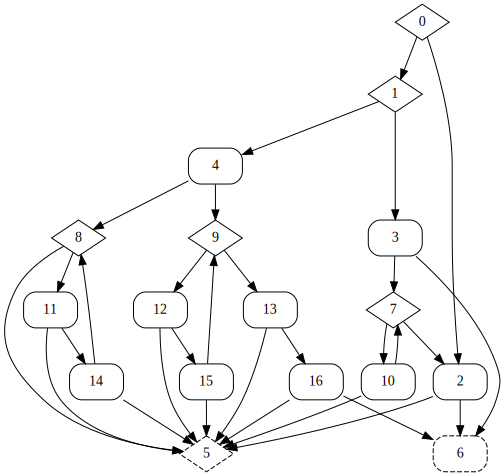

In [26]:
g = convert_to_backprop(a)
g

Let's mark the `bddtrue` state as winning and see if it propagates all the way up to state 0:

In [27]:
g.set_winner(6, True)

False

The return value simply says that the backpropagation did not determinate the initial state. 

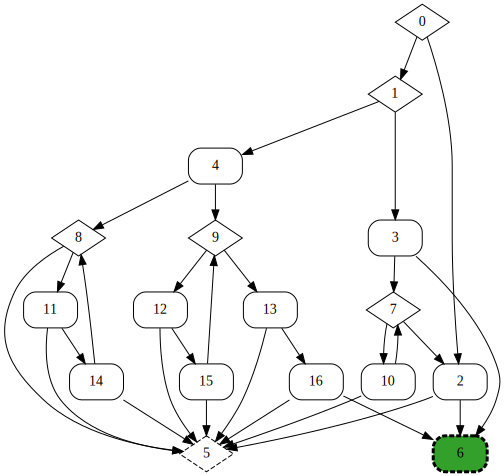

In [28]:
g

However if we set the bddfalse state to False, then this status will reach the initial state:

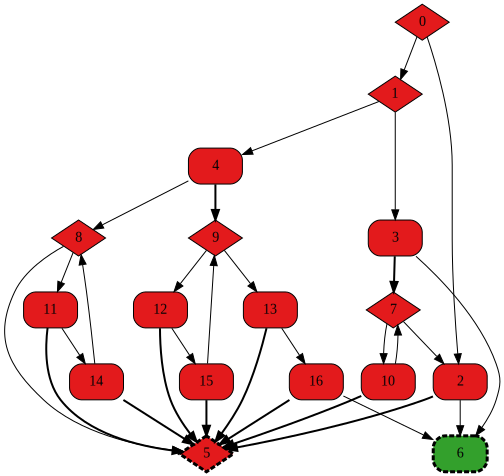

In [29]:
g.set_winner(5, False)
g

In [30]:
print(g.num_edges())

30


If we do the online version, we will create fewer states and fewer edges:

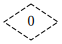

processing state 0


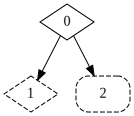

processing state 1


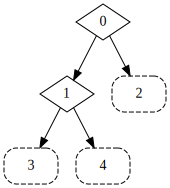

processing state 2


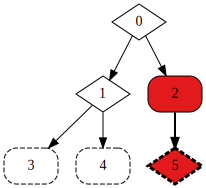

processing state 3


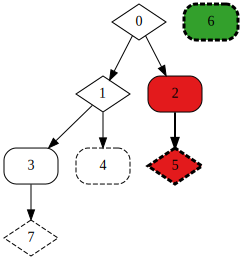

processing state 4


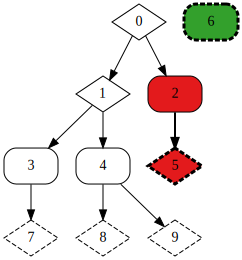

processing state 7


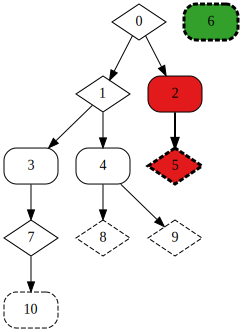

processing state 8


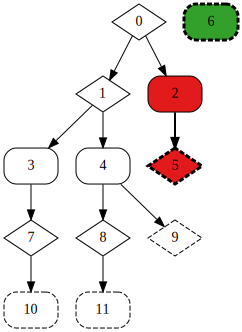

processing state 9


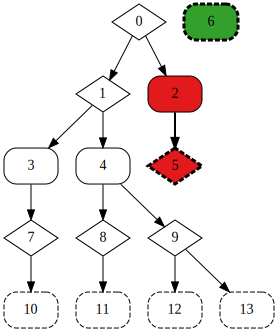

processing state 10


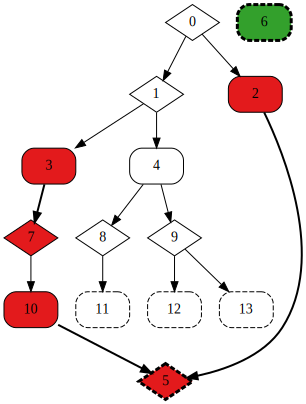

processing state 11


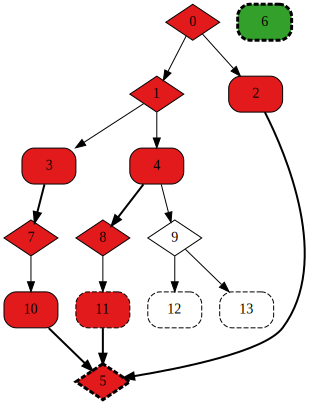

In [31]:
g = convert_to_backprop(a, online=True, display_each_step=True)
g

In [32]:
print(g.num_edges())

11


Here we could stop early because we found that player False had a strategy to reach `bddfalse`.

## Undetermined initial state example

Here is a very small example where neither player has a strategy to reach their respective sink.  In the context of LTLf synthesis, this means that player False can prevent player True from reaching `bddtrue`, which means that the specification is unrealizable.

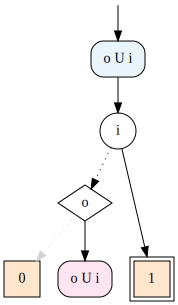

In [33]:
with spot.bdd_dict_preorder("i") as d:
    b = spot.ltlf_to_mtdfa('o U i', dict=d)
    b.set_controllable_variables(["o"])
    b = spot.mtdfa_restrict_as_game(b)
b

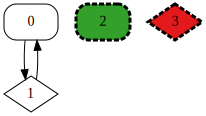

In [34]:
g = convert_to_backprop(b, online=True)
g

# Spot's `mtdfa_to_backprop`

Spot's has a C++ implementation of the the conversion to `backprop_graph` that is similar to the above prototype, except that an extra node is added to represent each state (with the state's BDD root as only successor).  You can also think of this extra node as representing the terminal node.  This extra node is not necessary when converting an MTDFA to `backprop_graph` as done by `mtdfa_to_backprop`, however it is useful when building the `backprop_graph` on-the-fly during the translation: when we reach a terminal, we can create a node for that state even if we do not know yet the BDD for that state.

`mtdfa_to_backprop` takes three arguments: `dfa`, `early_stop`, `preserve_names`.  The `dfa` argument is the MTDFA to convert.  The `early_stop` argument indicates if the conversion should stop as soon as the initial state is determined.  Finally, the `preserve_names` argument, requests that the node representing states of the MTDFA are named using the same of the original automaton.

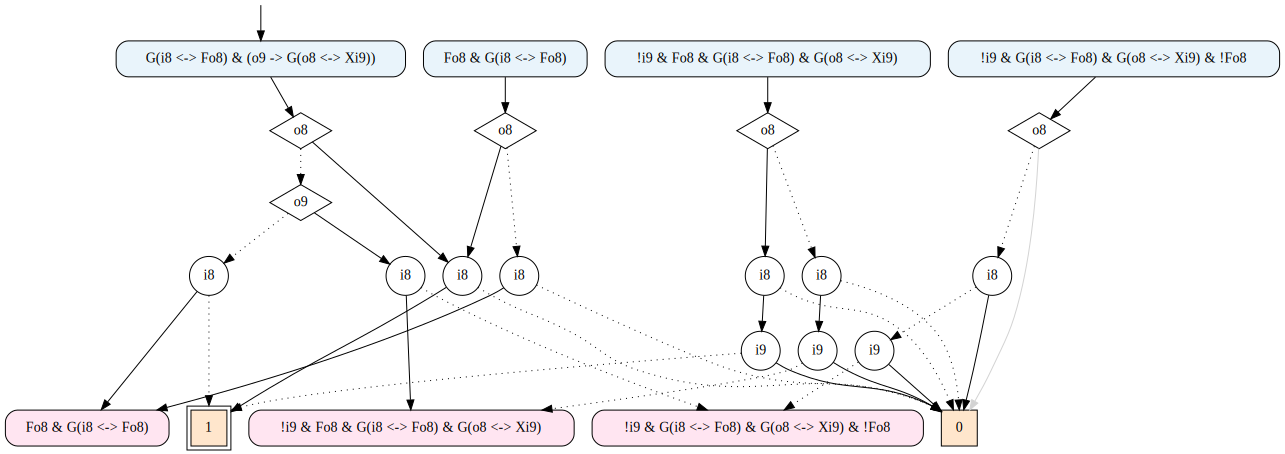

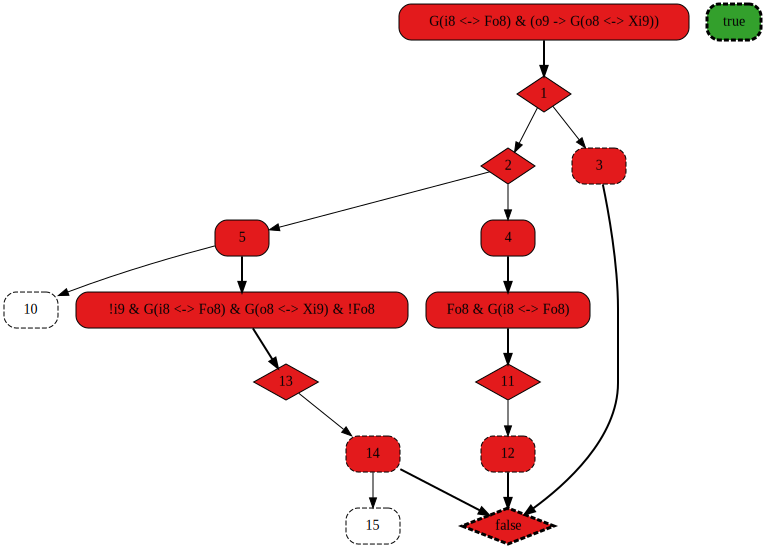

In [35]:
display(a)
spot.mtdfa_to_backprop(a, True, True)

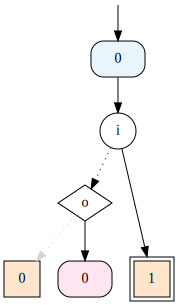

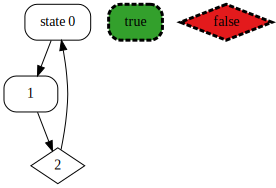

In [36]:
b.names.clear()  # Make sure we do not crash in the absence of names...
display(b)
spot.mtdfa_to_backprop(b, True, True)